<img src="Images/1200px-University_of_Tehran_logo.svg.png" width="100" style="float:left;"/>

<img src="Images/fanni.png" width="120" style="float:right;position: relative;top: -25px;"/>


<h1 style="float:center;" align="center">Computer Assignment 5</h1>
<h3 style="float:center;" align="center"><b> Navid Akbari ( 810895023 ) </b></h3>

This computer assignment goal is to get more familiar with the Multi-layer Neural Networks by classifying images. We use the Pytorch library, which is one of the best machine learning libraries. In this computer assignment, we classify one dataset related to different products.

In [1]:
import torchvision
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from datetime import timedelta
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/Colab Notebooks/categorized_products.zip" -d ""

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/Colab Notebooks/categorized_products.zip
replace categorized_products/Accessory Gift Set/19929.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


I use the `get_dataset` function to get the dataset in a way that I want, we can have normalized or not normalized dataset, and `CustomToTensor` class is used to convert the PIL images to the way that PyTorch can use them. Here we just used `Grayscale` function as a preprocessing step, but we can add some method to get the better result out of our dataset for sure.

In [2]:
class CustomToTensor(object):
    def __init__(self, normalized = False):
        self.normalized = normalized

    def __call__(self, image):
        if not self.normalized:
            image = np.array(image, dtype=np.float32)
        else:
            image = np.array(image, dtype=np.float32)/255
        return torch.from_numpy(image)

In [3]:
def get_dataset(isNormalized =  False):
    if not isNormalized:
        transform = transforms.Compose([transforms.Grayscale(), CustomToTensor()])
        dataset = ImageFolder("categorized_products", transform = transform)
        classes = dataset.classes
    else:
        transform = transforms.Compose([transforms.Grayscale(), CustomToTensor(normalized = True)])
        dataset = ImageFolder("categorized_products", transform = transform)
        classes = dataset.classes
    return dataset, classes

dataset, classes = get_dataset()

# Part 1

Here in the `show_sample` function we get the dataset we have and choose 12 different classes from it and show them.

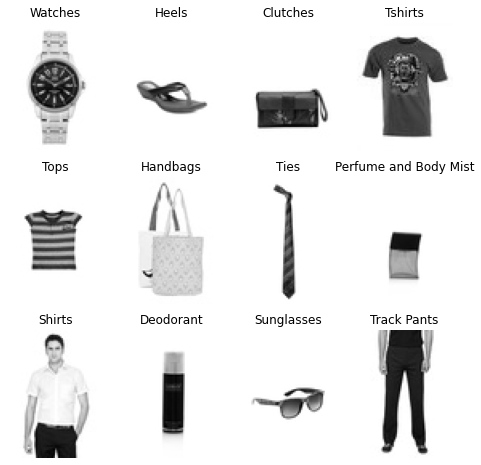

In [4]:
def show_samples(data, classes):
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:24]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=24)
    dataiter = iter(loader)
    images, labels = dataiter.next()

    different_images, different_labels = [], []
    index = 0
    while len(different_labels) < 12:
        if labels[index] not in different_labels:
            different_images.append(images[index])
            different_labels.append(labels[index])
        index = index + 1

    _, axs = plt.subplots(3, 4, figsize=(8,8)) 
    for i in range(3):
        for j in range(4):
            axs[i][j].imshow(different_images[i * 4 + j], cmap='gray')
            axs[i][j].set_title(classes[different_labels[i * 4 + j]])
            axs[i][j].axis('off')
    plt.show()

show_samples(dataset, classes)

# Part 2

Here in this section, we draw a bar graph of the number of the instance in different classes, and as we can see, we have an unbalanced dataset. The biggest class, which is for `Tshirt`, has about 3500 instances, while the smallest one, which is for `Kajal and Eyeliner`, has about 100 instances. In such a dataset, we usually can't get very high accuracy.

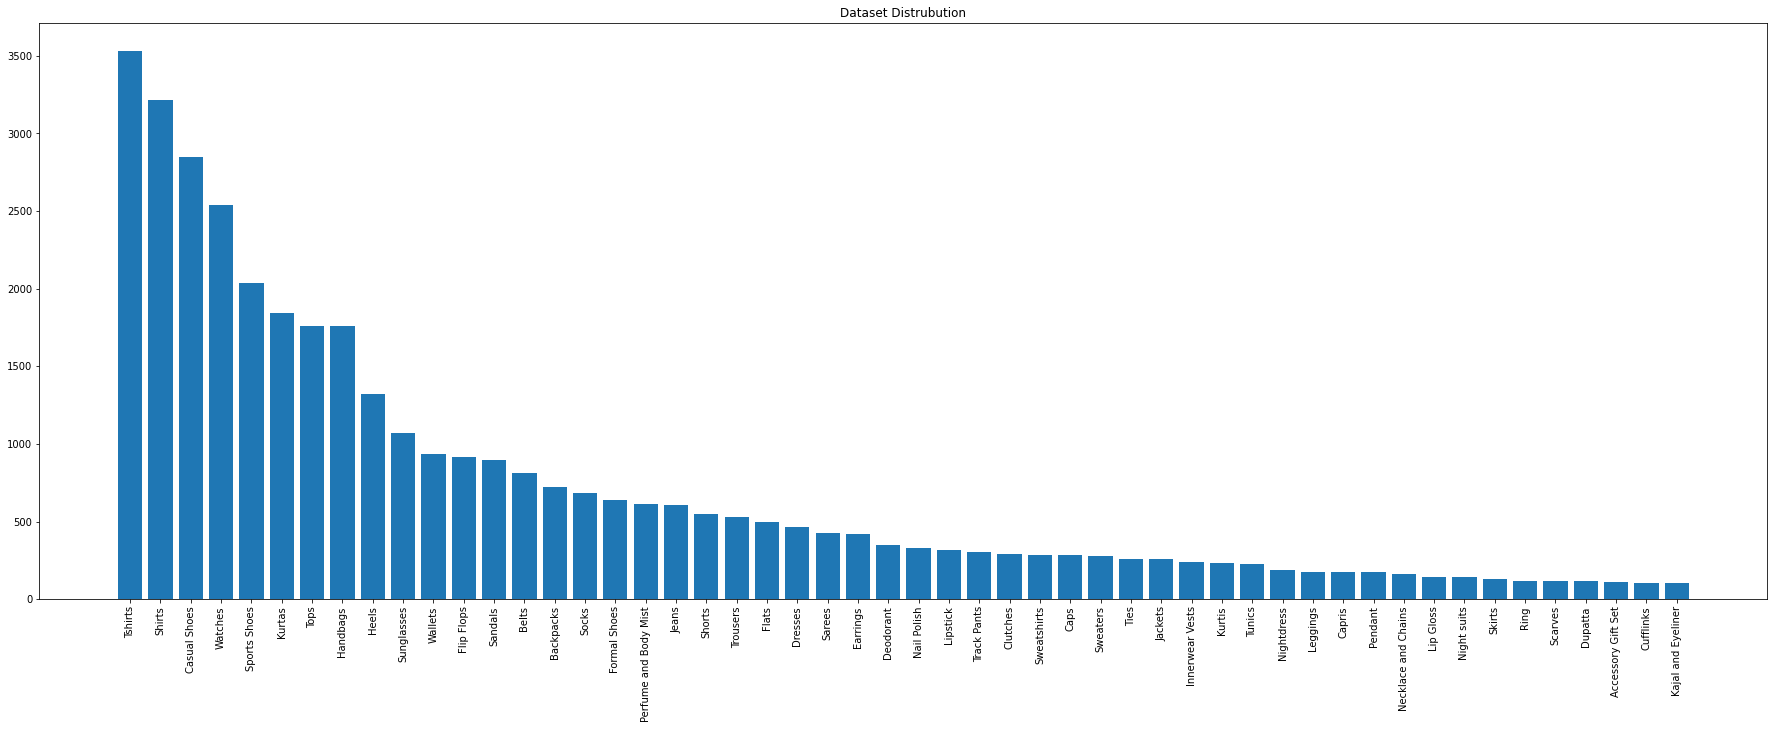

In [5]:
def distribution_graph(data, classes):
  loader = torch.utils.data.DataLoader(data, batch_size=24)
  total_category_count = {classes[i] : 0 for i in range(len(classes))}
  for _, labels in loader:
    for label in labels:
      total_category_count[ classes[label] ] += 1

  ordered_count = {k: v for k, v in sorted(total_category_count.items(), key=lambda item: item[1], reverse = True)}
  fig = plt.figure()
  ax = fig.add_axes([0,0,4,2])
  ax.bar(ordered_count.keys(), ordered_count.values())
  plt.xticks(rotation=90)
  plt.title('Dataset Distrubution')
  plt.show()
  

distribution_graph(dataset, classes)

# Model

Here we define the model that we used for training the dataset we have. The first layer should be in the size of the images we have, and because our images are 60*80, so the size should be 4800. For the next layers, I reduce the number of neurons linearly because I think we should gather the features we got from each image. I reduce 1200 neurons in each step, and I put four layers in my model. I have tried a lot of models for getting the best result out of our dataset, and I finally find out that reducing the number of neurons linearly will help the classification, and we can get better results out of it.

In [6]:
class Model(nn.Module):
    def __init__(self, class_num, act = F.relu, zero_weight = False):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(4800, 3600)
        self.act1 = act

        self.layer2 = nn.Linear(3600, 2400)
        self.act2 = act

        self.layer3 = nn.Linear(2400, 1200)
        self.act3 = act

        self.layer4 = nn.Linear(1200, class_num)

        if zero_weight:
            self.layer1.weight.data.fill_(0)
            self.layer2.weight.data.fill_(0)
            self.layer3.weight.data.fill_(0)
            self.layer4.weight.data.fill_(0)
            self.layer1.bias.data.fill_(0)
            self.layer2.bias.data.fill_(0)
            self.layer3.bias.data.fill_(0)
            self.layer4.bias.data.fill_(0)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)

        return x

Here I defined some useful functions for avoiding duplicate codes. I used these functions to set up the training parameters used for different parts of the project.

The `get_loader` function gets the number of batch size and split the dataset to the train and test sets and return `train_loader` and `test_loader`.

The `configuration` function gets different parameters and set up the model specifications and return `model` and loss `criterion` and `optimizer`.

The `fit` function, fit the model with the given parameters, and return it.

Then, I implement some classes to get the results of the model as the project want.


In [7]:
def get_loaders(dataset, batch_size = 64):
    targets = dataset.targets
    train_indices, test_indices = train_test_split(np.arange(len(targets)), test_size=0.2, shuffle=True, stratify=targets)

    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler=train_sampler, num_workers=16)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler=test_sampler, num_workers=16)

    return train_loader, test_loader

In [8]:
def configuration(learning_rate = 0.01, show_model_parameters = False, zero_weight = False, momentum = 0, activation_funtion = F.relu, weight_decay = 0):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = Model(len(classes), act = activation_funtion, zero_weight = zero_weight)
    model = model.to(device)

    if show_model_parameters:
        for name, param in model.named_parameters(): 
                print(name, ' -> ' ,param.numel())
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

    return model, device, criterion, optimizer

In [9]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10, show_last_epoch = False):

  total_time = 0.
  average_loss = []
  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

      average_loss.append(train_loss / len(train_loader))
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
    #   for p in model.parameters():
    #       print(p)
      if not show_last_epoch:
          print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss[-1], seconds))
      if show_last_epoch and epoch == range(num_epochs)[-1]:
          print('last epoch %d, train_loss: %.3f' % (epoch + 1, average_loss[-1]))
  print('total training time: %.3f minutes' % (total_time / 60))
  return average_loss, model

In [10]:
def train_test_accuracy(model, train_loader, test_loader):     
    correct = 0.
    total = 0.
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()

    test_accuracy = 100 * correct / total

    correct = 0.
    total = 0.
    with torch.no_grad():
      for images, labels in train_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()

    train_accuracy = 100 * correct / total


    print('Train Accuracy: {}%'.format(train_accuracy) + '  ' + 'Test Accuracy: {}%'.format(test_accuracy))

In [11]:
def classes_accuracy(model, train_loader, test_loader, classes):

    train_correct = {classes[i] : 0 for i in range(len(classes))}
    train_total = {classes[i] : 0 for i in range(len(classes))}
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            
            for distinct_label in list(set(labels.tolist())):
                train_total[ classes[distinct_label] ] += (labels == distinct_label).sum().item()
                for i in range(len(labels)):
                    if labels[i].tolist() is distinct_label:
                        if predicted[i].tolist() is distinct_label:
                            train_correct[ classes[distinct_label] ] += 1

    train_accuracy = {classes[i] : train_correct[classes[i]]/train_total[classes[i]] for i in range(len(classes))}

    test_correct = {classes[i] : 0 for i in range(len(classes))}
    test_total = {classes[i] : 0 for i in range(len(classes))}
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            
            for distinct_label in list(set(labels.tolist())):
                test_total[ classes[distinct_label] ] += (labels == distinct_label).sum().item()
                for i in range(len(labels)):
                    if labels[i].tolist() is distinct_label:
                        if predicted[i].tolist() is distinct_label:
                            test_correct[ classes[distinct_label] ] += 1

    test_accuracy = {classes[i] : test_correct[classes[i]]/test_total[classes[i]] for i in range(len(classes))}

    return train_accuracy, test_accuracy

In [12]:
def draw_classes_accuracy_graph(train_accuracy, test_accuracy):

    x = np.arange(len(train_accuracy.keys()))
    width = 0.35
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    rects1 = ax.bar(x - width/2, train_accuracy.values(), width, label='Train')
    rects2 = ax.bar(x + width/2, test_accuracy.values(), width, label='Test')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy of the Train and Test data in each classes')
    ax.set_xticks(x)
    ax.set_xticklabels(train_accuracy.keys())
    ax.legend()

    fig.tight_layout()
    plt.xticks(rotation=90)
    plt.show()

In [13]:
def draw_loss_graph(loss):
    plt.plot(loss)
    plt.title("Model rate")
    plt.xlabel("Epoch")
    plt.ylabel("Loss rate")
    plt.show()

# Part 3

Here we define our first model. In this model, our database isn't normalized so we don't expect to get good results out of this model. Because we have a high variance here and our data input is big, between `0 to 255`, and hence we should get high loss in our model. Before fitting the model to the dataset, we check whether our model is true or not. Here we print out the number of weights and biases that should update in each iteration. As we can these numbers are logical because, for example, in the first layer we have `4800` neurons and in the second layer we have `3600` neurons; hence we should have `4800*3600 = 17280000` weights and `3600` biases that we should update. So our model is correct.

In [14]:
dataset, classes = get_dataset()
train_loader, test_loader = get_loaders(dataset)
model, device, criterion, optimizer = configuration(show_model_parameters = True)

layer1.weight  ->  17280000
layer1.bias  ->  3600
layer2.weight  ->  8640000
layer2.bias  ->  2400
layer3.weight  ->  2880000
layer3.bias  ->  1200
layer4.weight  ->  62400
layer4.bias  ->  52



After fitting the dataset to the model, we see that our `train_loss` is `nan`. The reason for this problem is `Normalization`. We don't normalize the dataset we got so the data input is between 0 to 255 and these values are very big and cause the gradient in each step to become bigger and bigger, and after a few steps its become very big and so it overflows and python shows it as `nan`. For solving this problem, we should normalize our dataset, which we will do in next part. It's worth mentioning that this nan values could be solved by reducing the learning rate or increasing in the numbers of layers.

In [15]:
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: nan, time elapsed: 14.939189 seconds
epoch 2, train_loss: nan, time elapsed: 14.575667 seconds
epoch 3, train_loss: nan, time elapsed: 14.53569 seconds
epoch 4, train_loss: nan, time elapsed: 14.503348 seconds
epoch 5, train_loss: nan, time elapsed: 14.538472 seconds
epoch 6, train_loss: nan, time elapsed: 14.65556 seconds
epoch 7, train_loss: nan, time elapsed: 14.600737 seconds
epoch 8, train_loss: nan, time elapsed: 14.724474 seconds
epoch 9, train_loss: nan, time elapsed: 14.934427 seconds
epoch 10, train_loss: nan, time elapsed: 14.654134 seconds
total training time: 2.444 minutes



As the `train_loss` in the previous section was `nan` we expected that our accuracy be very low, and the result shows it too. Here the result shows that we have about `0.3%` accuracy. This result is just for the first category of our dataset. In fact, the model that we had didn't train at all and for all inputs choose the first category and the graph in the next section shows this matter as well.

In [16]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 0.29866774052820566%  Test Accuracy: 0.2953020134228188%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


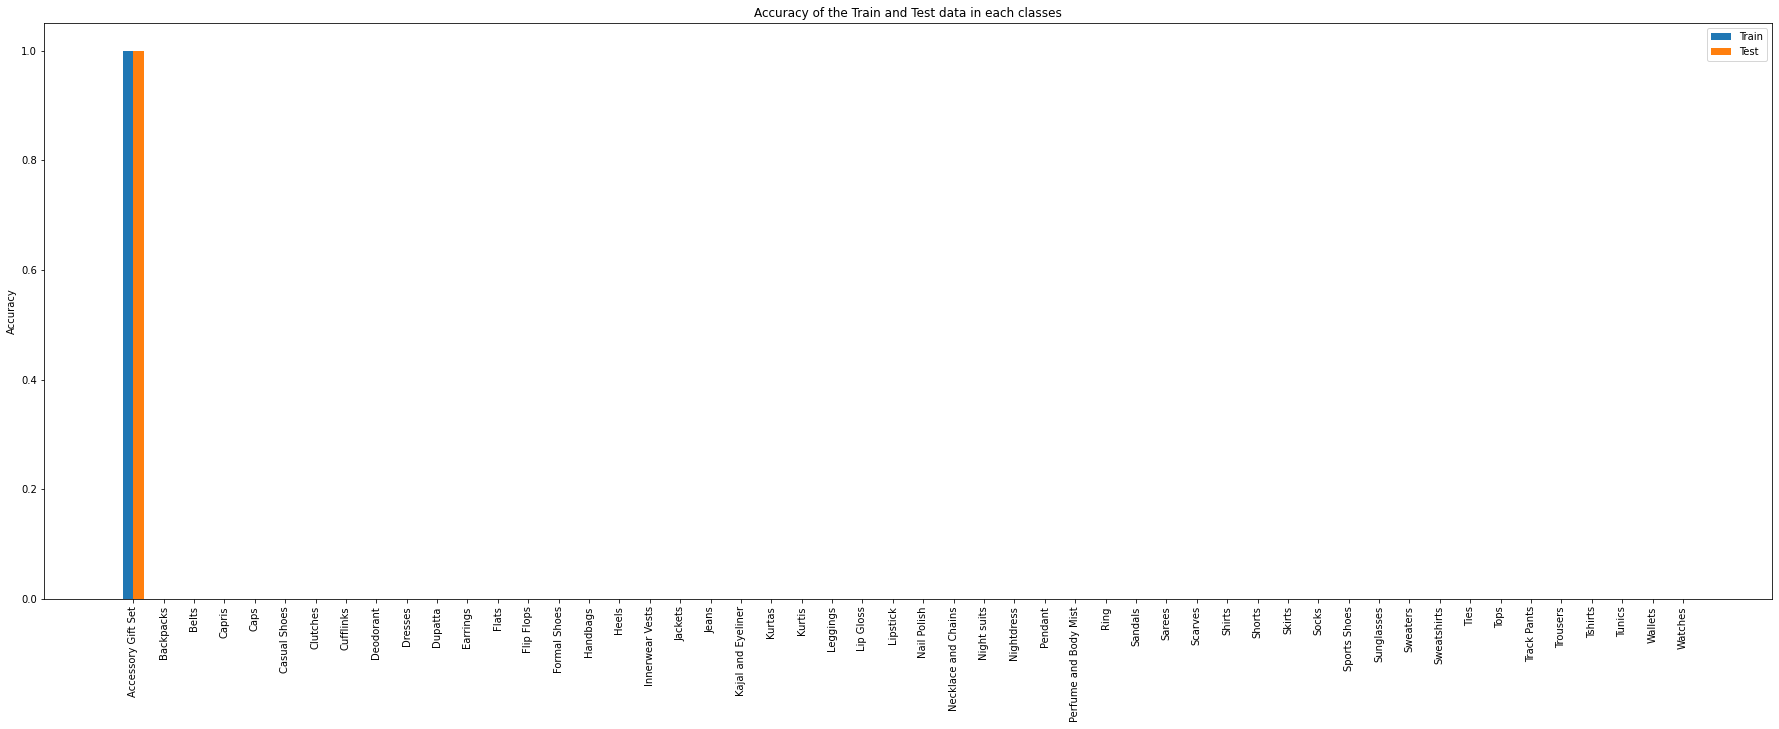

In [17]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

As the `train_loss` was `nan` in all epochs, so we can't have any figure to show its progress.

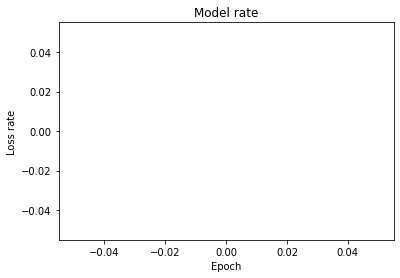

In [18]:
draw_loss_graph(loss)

# Part 4

In this section, we will normalize our dataset to get rid of `nan` values in the previous section.

In [26]:
dataset, classes = get_dataset(isNormalized = True)
train_loader, test_loader = get_loaders(dataset)

Here we can see that our model works logically, and the training loss becomes smaller in each epoch. This means that our model is working correctly and we have a good model here that fit to the dataset well. I tried a lot of models to find the best model which fits well to our dataset and I find out that the linear model will work good enough on our dataset.

The difference between this section and the previous one is just the normalization of the dataset. Normalizing means that we scale the data, which is between 0 to 255, to the range of 0 to 1. This work helps the loss calculation method because the values become smaller, and the gradients' values in each step didn't become very large and update normally and sufficiently updated the weights, and thus the model works well.

In [27]:
model, device, criterion, optimizer = configuration()
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 3.147, time elapsed: 14.771931 seconds
epoch 2, train_loss: 2.354, time elapsed: 14.909426 seconds
epoch 3, train_loss: 1.939, time elapsed: 14.613705 seconds
epoch 4, train_loss: 1.708, time elapsed: 14.60577 seconds
epoch 5, train_loss: 1.556, time elapsed: 14.667912 seconds
epoch 6, train_loss: 1.451, time elapsed: 14.574105 seconds
epoch 7, train_loss: 1.376, time elapsed: 14.702644 seconds
epoch 8, train_loss: 1.300, time elapsed: 15.727646 seconds
epoch 9, train_loss: 1.254, time elapsed: 14.95682 seconds
epoch 10, train_loss: 1.214, time elapsed: 14.812563 seconds
total training time: 2.472 minutes


As you can see accuracy is about `62%` here, which is good for our unbalanced dataset.

In [28]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 62.43833685694151%  Test Accuracy: 61.16778523489933%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


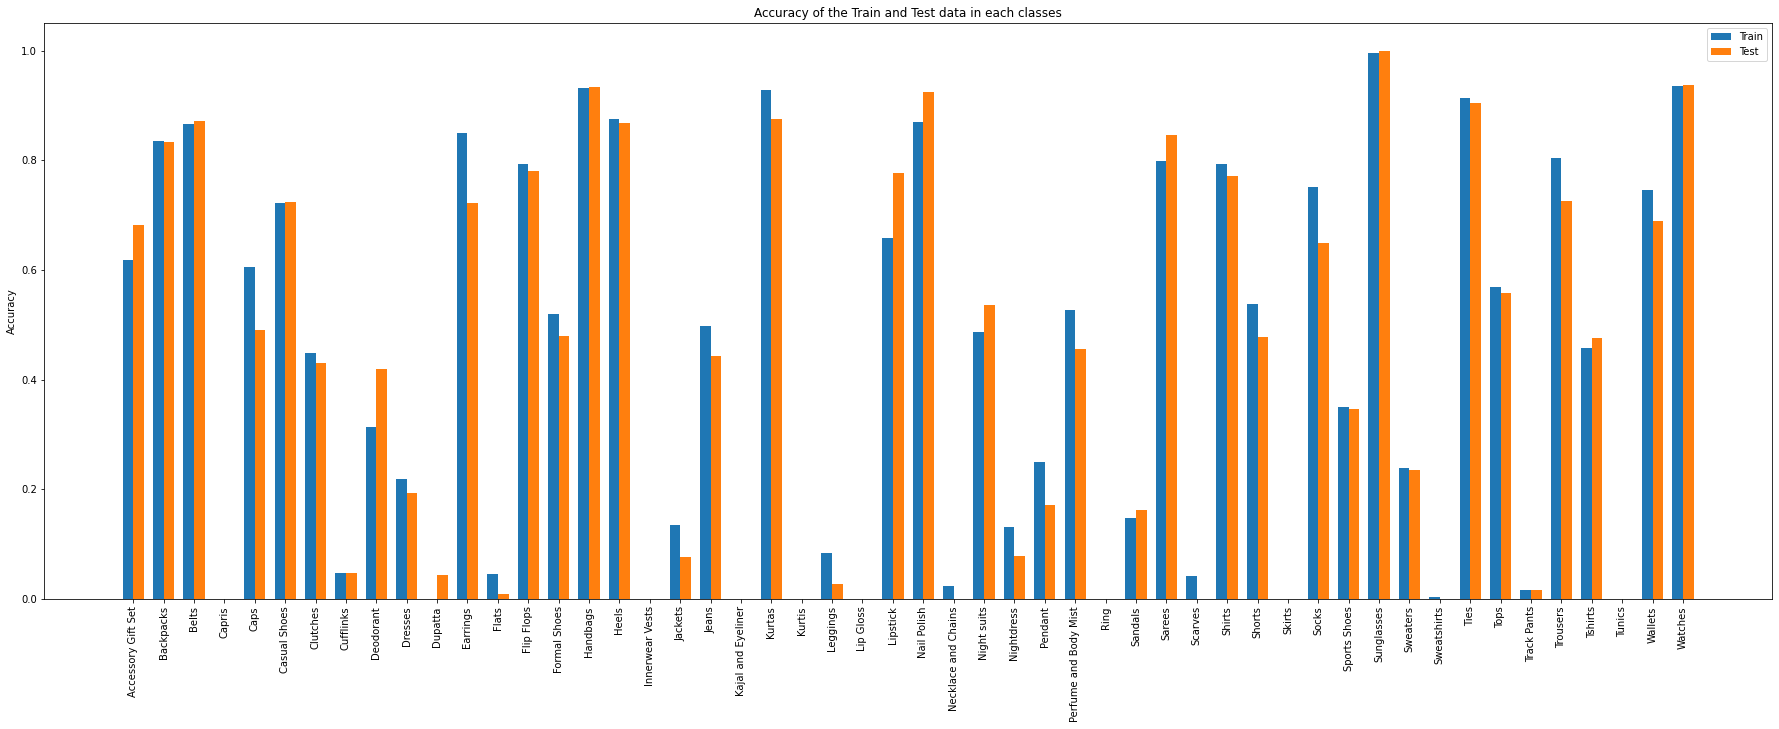

In [29]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

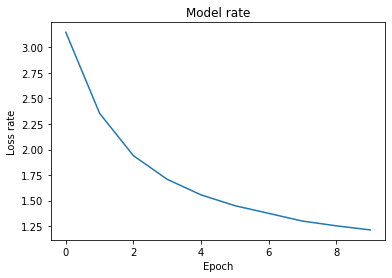

In [30]:
draw_loss_graph(loss)

# Part 5 - a

In this section we define our model in a way that all weights and biases initialized with 0.

In [31]:
model, device, criterion, optimizer = configuration(zero_weight = True)

When we initialized all the weights and biases to the zero, they will not update in the backpropagation phase because all neurons' values are zero. So all the weights and biases expect the last layer biases will be zero all the time and in each epoch. So just the last layer biases will change through the epochs. This matter will affect the convergence of the model, and the `train_loss` didn't change significantly during the fitting process. This leads the model to become a linear classifier and just classify the class with the most occurrence, which is `Tshirt` class. Hence our accuracy changes significantly and reduces to `9.5%`.

In [32]:
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 3.896, time elapsed: 15.092776 seconds
epoch 2, train_loss: 3.798, time elapsed: 14.813468 seconds
epoch 3, train_loss: 3.720, time elapsed: 14.778796 seconds
epoch 4, train_loss: 3.661, time elapsed: 15.060826 seconds
epoch 5, train_loss: 3.616, time elapsed: 14.933846 seconds
epoch 6, train_loss: 3.582, time elapsed: 15.003171 seconds
epoch 7, train_loss: 3.557, time elapsed: 15.506442 seconds
epoch 8, train_loss: 3.538, time elapsed: 15.456339 seconds
epoch 9, train_loss: 3.524, time elapsed: 15.415876 seconds
epoch 10, train_loss: 3.512, time elapsed: 15.325449 seconds
total training time: 2.523 minutes


In [33]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 9.48689553340716%  Test Accuracy: 9.48993288590604%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


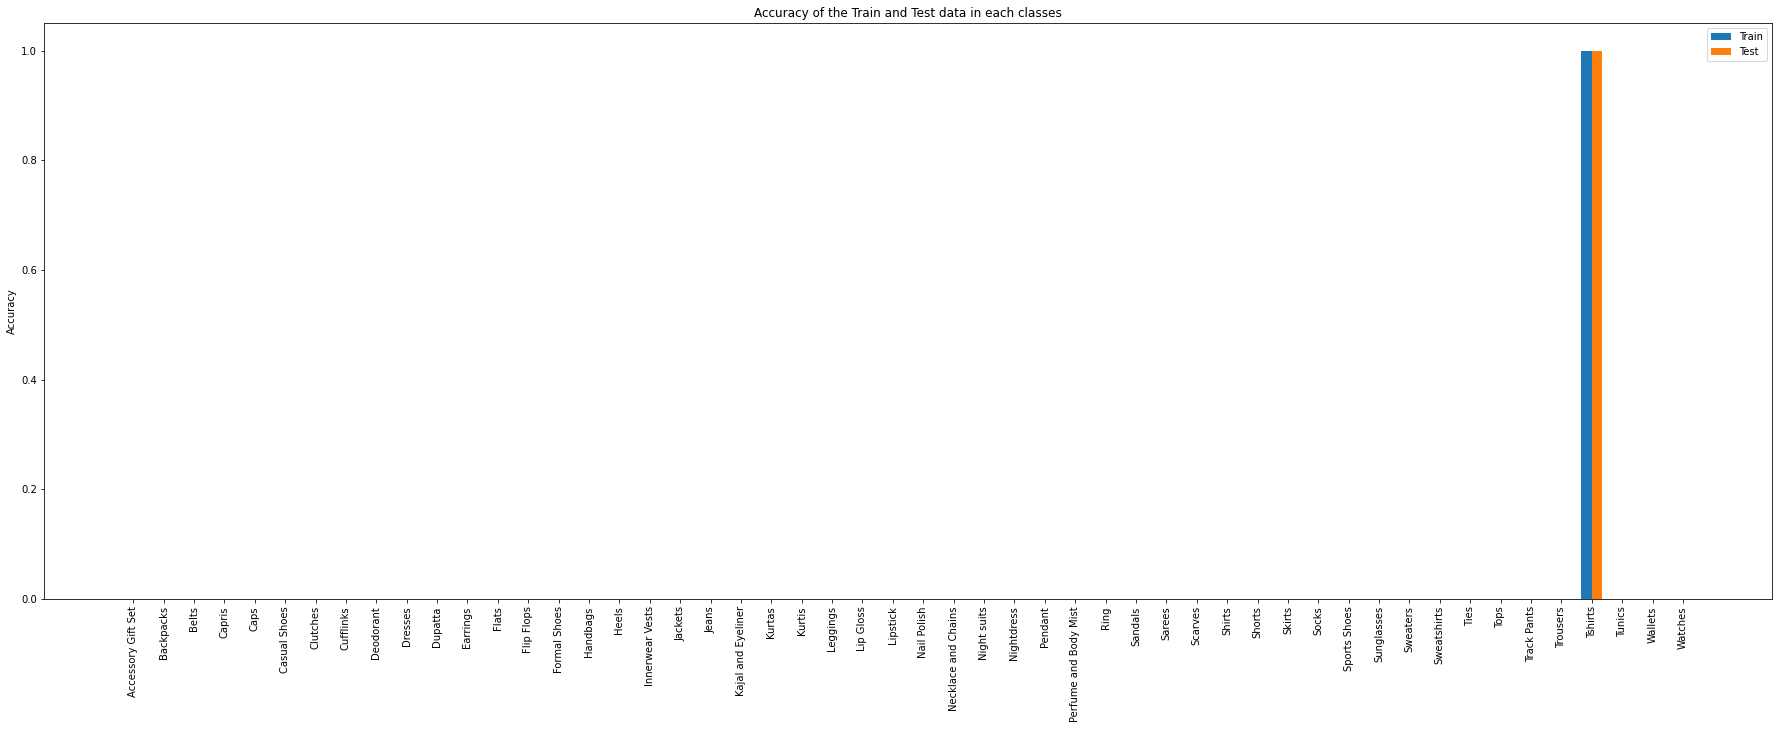

In [34]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

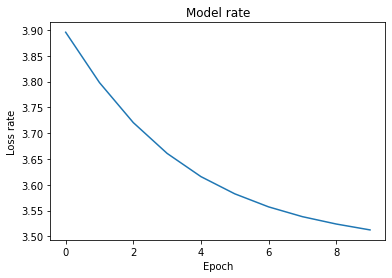

In [35]:
draw_loss_graph(loss)

# Part 5 - b


Initializing weights randomly is the best practice because when we have random weights, we move toward a minimum in different ways; hence the probability of stucking in local minimum decreased. But this method can potentially lead to two issues, vanishing gradients or exploding gradients. At first, we introduce what these problems are and then we introduce some ways to solve them. So, initializing weights randomly is a good practice just we should take care of said problems and if we were facing them, we should deal with them properly.

**Vanishing gradients**: For any activation function, `abs(dW)` will get smaller and smaller as we go backward with every layer during backpropagation. The earlier layers are the slowest to train in such a case. The weight update is minor and results in slower convergence. This makes the optimization of the loss function slow. In the worst case, this may completely stop the neural network from training further. More specifically, in the case of `sigmoid(z)` and `tanh(z)`, if your weights are large, then the gradient will be vanishingly small, effectively preventing the weights from changing their value. This is because `abs(dW)` will increase very slightly or possibly get smaller and smaller every iteration. With `RELU(z)`, vanishing gradients are generally not a problem as the gradient is 0 for negative inputs and 1 for positive inputs.

**Exploding gradients**: This is the exact opposite of vanishing gradients. Consider you have non-negative and large weights and small activations A (as can be the case for sigmoid(z)). When these weights are multiplied along the layers, they cause a large change in the cost. Thus, the gradients are also going to be large. This means that the changes in W, by `W — ⍺ * dW`, will be in huge steps, the downward moment will increase.
This may result in oscillating around the minima or even overshooting the optimum again and again and the model will never learn!
Another impact of exploding gradients is that huge values of the gradients may cause number overflow resulting in incorrect computations or introductions of `NaN’s`. This might also lead to the loss taking the value NaN.

For dealing with this problems, here we instroduce 3 ways and there are certainly other methods:
1. Using RELU/ leaky RELU as the activation function, as it is relatively robust to the vanishing/exploding gradient issue. In the case of leaky RELU’s, they never have 0 gradient. Thus they never die and training continues.

2. For deep networks, we can use a heuristic to initialize the weights depending on the non-linear activation function. Here, instead of drawing from standard normal distribution, we are drawing `W` from normal distribution with variance `k/n`, where k depends on the activation function. While these heuristics do not completely solve the exploding/vanishing gradients issue, they help mitigate it to a great extent.

3. Gradient Clipping — This is another way of dealing with the exploding gradient problem. We set a threshold value, and if a chosen function of a gradient is larger than this threshold, we set it to another value. For example, normalize the gradients when the L2 norm exceeds a certain threshold `W = W * threshold / l2_norm(W) if l2_norm(W) > threshold`

# Part 6 - a


In this section, we will try different `learning_rate` for finding the one that fits best to our model. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process. Therefore, we should not use a learning rate that is too large or too small. Nevertheless, we must configure the model in such a way that on average a *good enough* set of weights is found to approximate the mapping problem as represented by the training dataset.

For this purpose, at first I try some learning rate from very small to the big one to find the best period. As you can see, after running this step, I got the best result in a period of ‍‍`0.032` to `0.064`. Then I try some other learning rates in this smaller period to find the smaller period and I find that the best learning rate is between `0.052` and `0.06`. And finally, I tried this period and find that the best learning rate for my model is `0.053`.

In [36]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128]
for lr in learning_rates:
    print("Learning Rate is: " + str(lr))
    model, device, criterion, optimizer = configuration(learning_rate = lr)
    loss, model = fit(model, train_loader, device, criterion, optimizer, show_last_epoch = True)
    train_test_accuracy(model, train_loader, test_loader)
    print("--------------------------------")

Learning Rate is: 0.001
last epoch 10, train_loss: 2.630
total training time: 2.337 minutes
Train Accuracy: 29.0009731870197%  Test Accuracy: 28.80536912751678%
--------------------------------
Learning Rate is: 0.002
last epoch 10, train_loss: 2.001
total training time: 2.333 minutes
Train Accuracy: 42.30343300110742%  Test Accuracy: 41.57046979865772%
--------------------------------
Learning Rate is: 0.004
last epoch 10, train_loss: 1.546
total training time: 2.329 minutes
Train Accuracy: 52.40444310211752%  Test Accuracy: 51.651006711409394%
--------------------------------
Learning Rate is: 0.008
last epoch 10, train_loss: 1.270
total training time: 2.371 minutes
Train Accuracy: 61.05238430819826%  Test Accuracy: 59.53020134228188%
--------------------------------
Learning Rate is: 0.016
last epoch 10, train_loss: 1.110
total training time: 2.427 minutes
Train Accuracy: 65.93845431054733%  Test Accuracy: 64.32214765100672%
--------------------------------
Learning Rate is: 0.032
l

In [37]:
learning_rates = [0.032, 0.036, 0.04, 0.044, 0.048, 0.052, 0.056, 0.06 ,0.064]
for lr in learning_rates:
    print("Learning Rate is: " + str(lr))
    model, device, criterion, optimizer = configuration(learning_rate = lr)
    loss, model = fit(model, train_loader, device, criterion, optimizer, show_last_epoch = True)
    train_test_accuracy(model, train_loader, test_loader)
    print("--------------------------------")

Learning Rate is: 0.032
last epoch 10, train_loss: 0.995
total training time: 2.402 minutes
Train Accuracy: 61.988657337494544%  Test Accuracy: 59.50335570469799%
--------------------------------
Learning Rate is: 0.036
last epoch 10, train_loss: 0.985
total training time: 2.471 minutes
Train Accuracy: 68.78418738883855%  Test Accuracy: 66.13422818791946%
--------------------------------
Learning Rate is: 0.04
last epoch 10, train_loss: 0.968
total training time: 2.398 minutes
Train Accuracy: 66.74385046478069%  Test Accuracy: 64.8993288590604%
--------------------------------
Learning Rate is: 0.044
last epoch 10, train_loss: 0.963
total training time: 2.374 minutes
Train Accuracy: 67.01567166683446%  Test Accuracy: 65.2751677852349%
--------------------------------
Learning Rate is: 0.048
last epoch 10, train_loss: 0.958
total training time: 2.377 minutes
Train Accuracy: 66.64317594550153%  Test Accuracy: 64.8993288590604%
--------------------------------
Learning Rate is: 0.052
last

In [39]:
learning_rates = [0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06]
for lr in learning_rates:
    print("Learning Rate is: " + str(lr))
    model, device, criterion, optimizer = configuration(learning_rate = lr)
    loss, model = fit(model, train_loader, device, criterion, optimizer, show_last_epoch = True)
    train_test_accuracy(model, train_loader, test_loader)
    print("--------------------------------")

Learning Rate is: 0.052
last epoch 10, train_loss: 0.953
total training time: 2.435 minutes
Train Accuracy: 66.37806637806638%  Test Accuracy: 64.22818791946308%
--------------------------------
Learning Rate is: 0.053
last epoch 10, train_loss: 0.965
total training time: 2.460 minutes
Train Accuracy: 71.42185979395282%  Test Accuracy: 69.32885906040268%
--------------------------------
Learning Rate is: 0.054
last epoch 10, train_loss: 0.957
total training time: 2.395 minutes
Train Accuracy: 52.840699352327256%  Test Accuracy: 51.369127516778526%
--------------------------------
Learning Rate is: 0.055
last epoch 10, train_loss: 0.945
total training time: 2.396 minutes
Train Accuracy: 68.72713849458036%  Test Accuracy: 67.30201342281879%
--------------------------------
Learning Rate is: 0.056
last epoch 10, train_loss: 0.961
total training time: 2.452 minutes
Train Accuracy: 68.61975234068257%  Test Accuracy: 66.67114093959732%
--------------------------------
Learning Rate is: 0.057

In [44]:
best_learning_rate = 0.053
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate)
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 2.614, time elapsed: 14.850943 seconds
epoch 2, train_loss: 1.789, time elapsed: 14.905186 seconds
epoch 3, train_loss: 1.506, time elapsed: 14.92684 seconds
epoch 4, train_loss: 1.357, time elapsed: 14.660421 seconds
epoch 5, train_loss: 1.236, time elapsed: 14.869838 seconds
epoch 6, train_loss: 1.158, time elapsed: 14.882251 seconds
epoch 7, train_loss: 1.091, time elapsed: 16.165351 seconds
epoch 8, train_loss: 1.030, time elapsed: 14.776333 seconds
epoch 9, train_loss: 0.992, time elapsed: 14.770285 seconds
epoch 10, train_loss: 0.958, time elapsed: 14.826074 seconds
total training time: 2.494 minutes


In [45]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 70.47551931272862%  Test Accuracy: 68.42953020134229%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


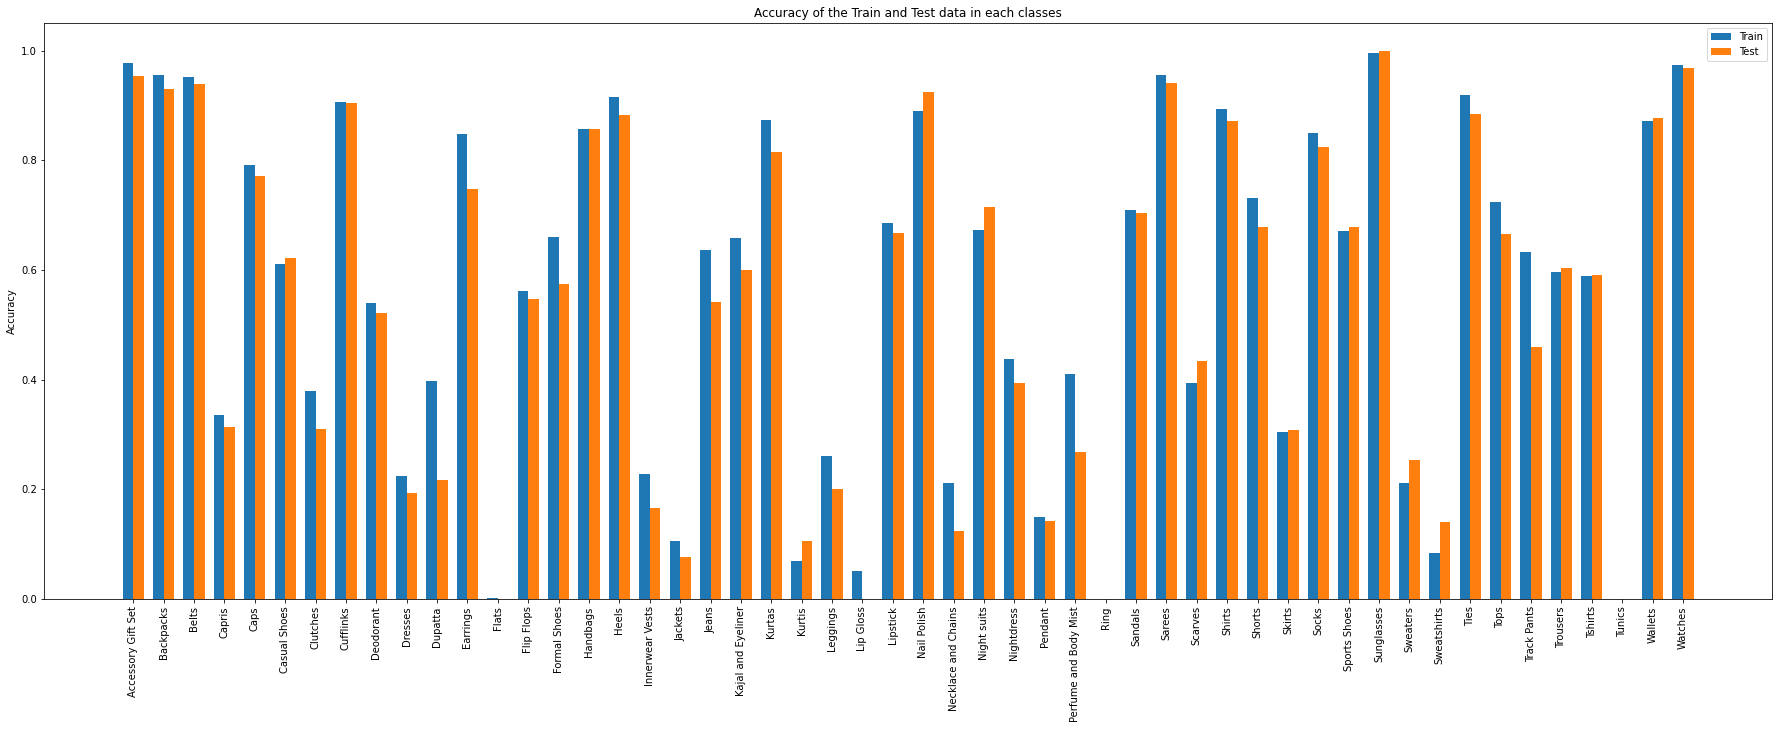

In [46]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

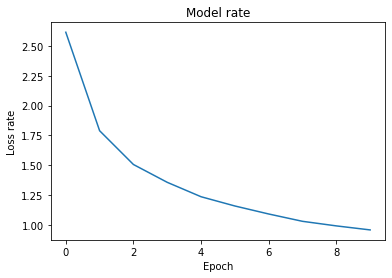

In [47]:
draw_loss_graph(loss)

# Part 6 - b

The learning rate controls how quickly the model is adapted to the problem. 
* **Very Big Learning Rate**: 
    1. Generally, a large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. 
    2. A learning rate that is too large will result in weight updates that will be too large and the performance of the model (such as its loss on the training dataset) will oscillate over training epochs. Oscillating performance is said to be caused by weights that diverge (are divergent). 
    3. When using high learning rates, it is possible to encounter a positive feedback loop in which large weights induce large gradients which then induce a large update to the weights. If these updates consistently increase the size of the weights, then the weight rapidly moves away from the origin until numerical overflow occurs.

* **Very Small Learning Rate**: 
    1. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train.  
    2. A learning rate that is too small may never converge or may get stuck on a suboptimal solution.

The image below show the differences between different Learning rate very good.
<img src="Images/5.png"/>


As the result below shows, for very small learining rate `0.001`, the model converge very slowly and can't reach to the optimum in 10 epochs. On the other hand, the very large learning rate `0.2` leads to oscillation in the `train_loss` and stuck in the local minimum


In [50]:
learning_rates = [0.001, 0.2]
for lr in learning_rates:
    print("Learning Rate is: " + str(lr))
    model, device, criterion, optimizer = configuration(learning_rate = lr)
    loss, model = fit(model, train_loader, device, criterion, optimizer)
    train_test_accuracy(model, train_loader, test_loader)
    print("--------------------------------")

Learning Rate is: 0.001
epoch 1, train_loss: 3.846, time elapsed: 12.945674 seconds
epoch 2, train_loss: 3.596, time elapsed: 12.837101 seconds
epoch 3, train_loss: 3.463, time elapsed: 13.096119 seconds
epoch 4, train_loss: 3.425, time elapsed: 12.864431 seconds
epoch 5, train_loss: 3.400, time elapsed: 12.837071 seconds
epoch 6, train_loss: 3.373, time elapsed: 13.167205 seconds
epoch 7, train_loss: 3.341, time elapsed: 13.19577 seconds
epoch 8, train_loss: 3.298, time elapsed: 13.495207 seconds
epoch 9, train_loss: 3.243, time elapsed: 13.181487 seconds
epoch 10, train_loss: 3.176, time elapsed: 13.292551 seconds
total training time: 2.182 minutes
Train Accuracy: 18.165039095271652%  Test Accuracy: 18.201342281879196%
--------------------------------
Learning Rate is: 0.2
epoch 1, train_loss: 3.503, time elapsed: 13.419712 seconds
epoch 2, train_loss: 3.439, time elapsed: 13.09118 seconds
epoch 3, train_loss: 3.420, time elapsed: 13.233759 seconds
epoch 4, train_loss: 3.424, time el

# Part 7 - a

In this section we check effects of the `batch_size` on our model. The number of examples from the training dataset used in the estimate of the error gradient is called the batch size and is an important hyperparameter that influences the dynamics of the learning algorithm. We often want to use a larger batch size to train our models as it allows computational speedups from the parallelism of GPUs. However, **too large batch** size will lead to poor generalization. For convex functions that we are trying to optimize, there is an inherent tug-of-war between the benefits of smaller and bigger batch sizes. On the one extreme, using a batch equal to the entire dataset guarantees convergence to the global optima of the objective function. However, this is at the cost of slower, empirical convergence to that optima. On the other hand, using **smaller batch** sizes have been empirically shown to have faster convergence to *good* solutions. This is intuitively explained by the fact that smaller batch sizes allow the model to start learning before having to see all the data. The downside of using a smaller batch size is that the model is not guaranteed to converge to the global optima. Therefore, under no computational constraints, it is often advised that one starts at a small batch size, reaping the benefits of faster training dynamics, and steadily grows the batch size through training, also reaping the benefits of guaranteed convergence.

In [49]:
batch_size = [32, 128]
for bs in batch_size:
    print("Batch size is: " + str(bs))
    train_loader, test_loader = get_loaders(dataset, batch_size = bs)
    model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate)
    loss, model = fit(model, train_loader, device, criterion, optimizer, show_last_epoch = True)
    train_test_accuracy(model, train_loader, test_loader)
    print("--------------------------------")

Batch size is: 32
last epoch 10, train_loss: 0.869
total training time: 2.964 minutes
Train Accuracy: 71.69703681331589%  Test Accuracy: 69.00671140939598%
--------------------------------
Batch size is: 128
last epoch 10, train_loss: 1.115
total training time: 2.150 minutes
Train Accuracy: 63.790731232591696%  Test Accuracy: 63.2751677852349%
--------------------------------


# Part 7 - b

As much as the batch size increased, we compare more and more data in one step so we have more evidence in each iteration, so it seems that it is better to increase the learning rate too. And as [this](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e) article state: "Some works in the optimization literature have shown that increasing the learning rate can compensate for larger batch sizes. With this in mind, we ramp up the learning rate for our model to see if we can recover the asymptotic test accuracy we lost by increasing the batch size."

And our results show the stated reasons too.

In [56]:
learning_rate = [0.1, 0.01]
for lr in learning_rate:
    print("Learning rate is: " + str(lr))
    train_loader, test_loader = get_loaders(dataset, batch_size = 128)
    model, device, criterion, optimizer = configuration(learning_rate = lr)
    loss, model = fit(model, train_loader, device, criterion, optimizer, show_last_epoch = True)
    train_test_accuracy(model, train_loader, test_loader)
    print("--------------------------------")

Learning rate is: 0.1
last epoch 10, train_loss: 1.120
total training time: 2.314 minutes
Train Accuracy: 65.95523339709386%  Test Accuracy: 65.06040268456375%
--------------------------------
Learning rate is: 0.01
last epoch 10, train_loss: 1.493
total training time: 2.339 minutes
Train Accuracy: 52.33732675593141%  Test Accuracy: 52.76510067114094%
--------------------------------


# Part 8 - a

In this section we check out effect of the momentum hyperparameter  in optimizer. `SGD with momentum` is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging. The momentum formula is given below and the momentum parameter in this formula is `&gamma;`. What we get with this is an exponentially weighted moving average of the gradient, implying the progress is faster when we moving in the right direction and the possible oscillation when we rebound in the loss function. Both features make convergence happen faster.
<img src="Images/3.png" style="height:80px;"/>

**Pros:**
With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives are noisy. So, exponentially weighed averages can provide us a better estimate which is closer to the actual derivate than our noisy calculations. This is one reason why momentum might work better than classic SGD.

The other reason lies in ravines. Ravine is an area, where the surface curves much more steeply in one dimension than in another. Ravines are common near local minimas in deep learning and SGD has troubles navigating them. SGD will tend to oscillate across the narrow ravine since the negative gradient will point down one of the steep sides rather than along the ravine towards the optimum. Momentum helps accelerate gradients in the right direction. This is expressed in the following pictures(Left — SGD without momentum, right— SGD with momentum):

<img src="Images/2.png" style="width:500px;"/>

**Cons:**
If the momentum is too much, we will most likely miss the local minima, rolling past it, but then rolling backwards, missing it again. If the momentum is too much, we could just swing back and forward between the local minima.

# Part 8 - b

In this section, we will try different momentum for finding the best one for our model. As you can see, we try `0.5`, `0.9` and `0.98` for the momentum parameter. And the `0.5` was the best one for my model and led to about `70%` accuracy in my model, which is a very good result. But as much as I increase the momentum parameter, the accuracy of my model decreases and in the last try with `0.98` my model didn't even fit dataset and the `train_loss` becomes `nan`. The reason for this happens is that when we increase the momentum, the gradients become bigger and bigger and after some step the gradient becomes Inf and leads to the nan in the `train_loss`.

In [57]:
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate, momentum = 0.5)
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 2.631, time elapsed: 13.596513 seconds
epoch 2, train_loss: 1.950, time elapsed: 13.459539 seconds
epoch 3, train_loss: 1.594, time elapsed: 13.353656 seconds
epoch 4, train_loss: 1.385, time elapsed: 13.325237 seconds
epoch 5, train_loss: 1.274, time elapsed: 13.459205 seconds
epoch 6, train_loss: 1.154, time elapsed: 13.789036 seconds
epoch 7, train_loss: 1.110, time elapsed: 13.681574 seconds
epoch 8, train_loss: 1.044, time elapsed: 13.850452 seconds
epoch 9, train_loss: 1.000, time elapsed: 13.85463 seconds
epoch 10, train_loss: 0.973, time elapsed: 13.631612 seconds
total training time: 2.267 minutes


In [58]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 70.97218027450586%  Test Accuracy: 69.85234899328859%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


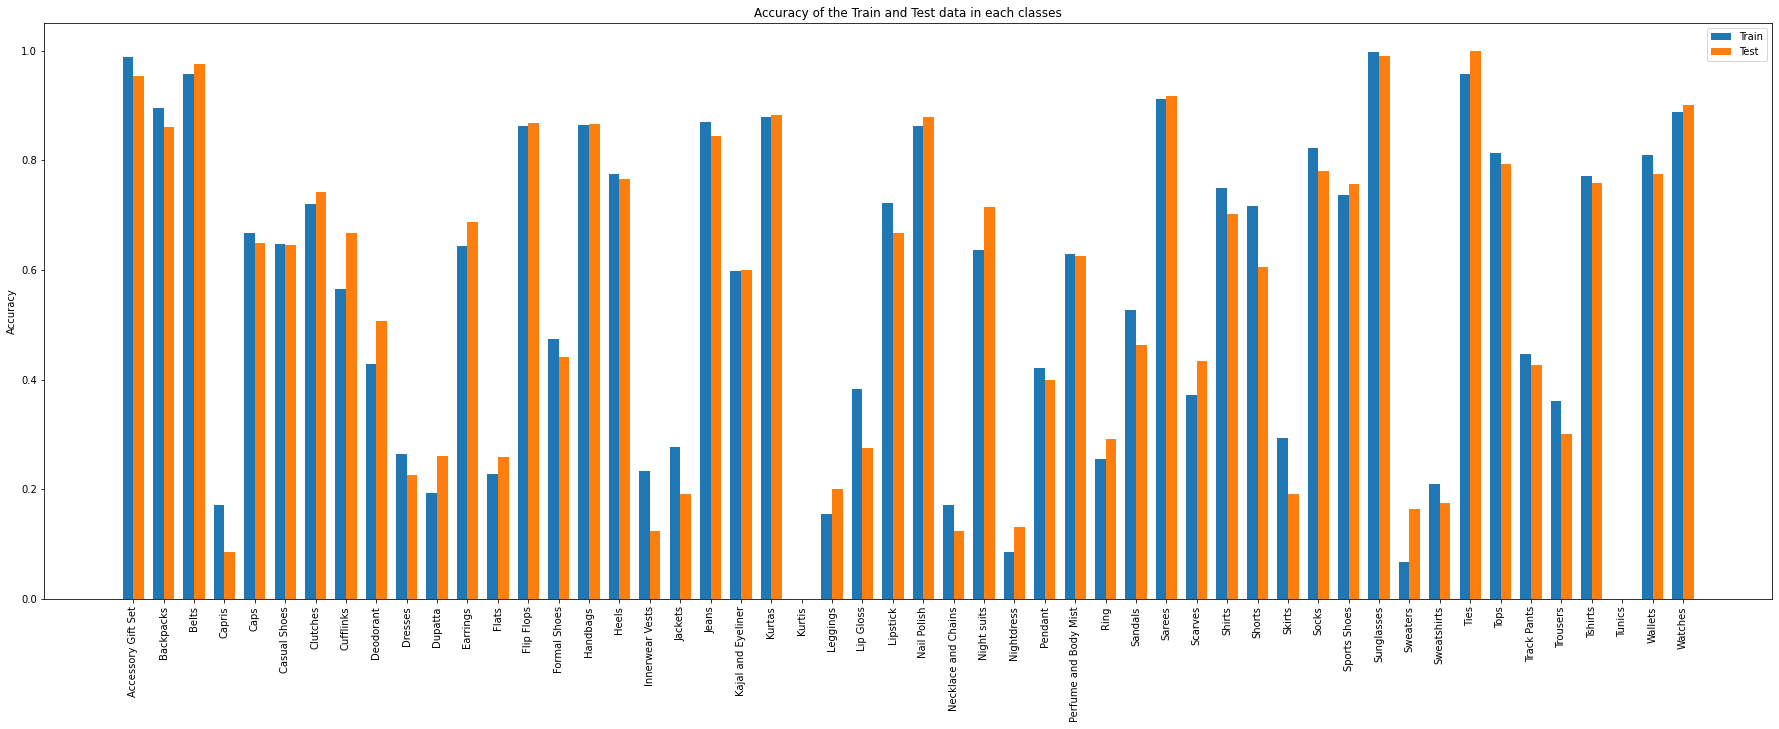

In [59]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

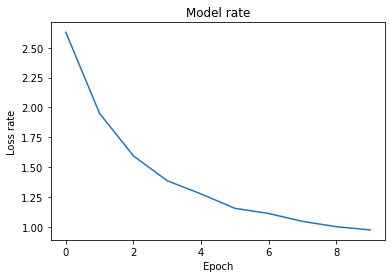

In [60]:
draw_loss_graph(loss)

In [61]:
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate, momentum = 0.9)
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 3.022, time elapsed: 14.027933 seconds
epoch 2, train_loss: 2.771, time elapsed: 13.814994 seconds
epoch 3, train_loss: 2.308, time elapsed: 13.988837 seconds
epoch 4, train_loss: 1.988, time elapsed: 13.900649 seconds
epoch 5, train_loss: 1.781, time elapsed: 13.841635 seconds
epoch 6, train_loss: 1.737, time elapsed: 14.034066 seconds
epoch 7, train_loss: 1.717, time elapsed: 14.085896 seconds
epoch 8, train_loss: 1.585, time elapsed: 13.864754 seconds
epoch 9, train_loss: 1.621, time elapsed: 13.931091 seconds
epoch 10, train_loss: 1.564, time elapsed: 14.923116 seconds
total training time: 2.340 minutes


In [62]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 49.58891237961005%  Test Accuracy: 49.59731543624161%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


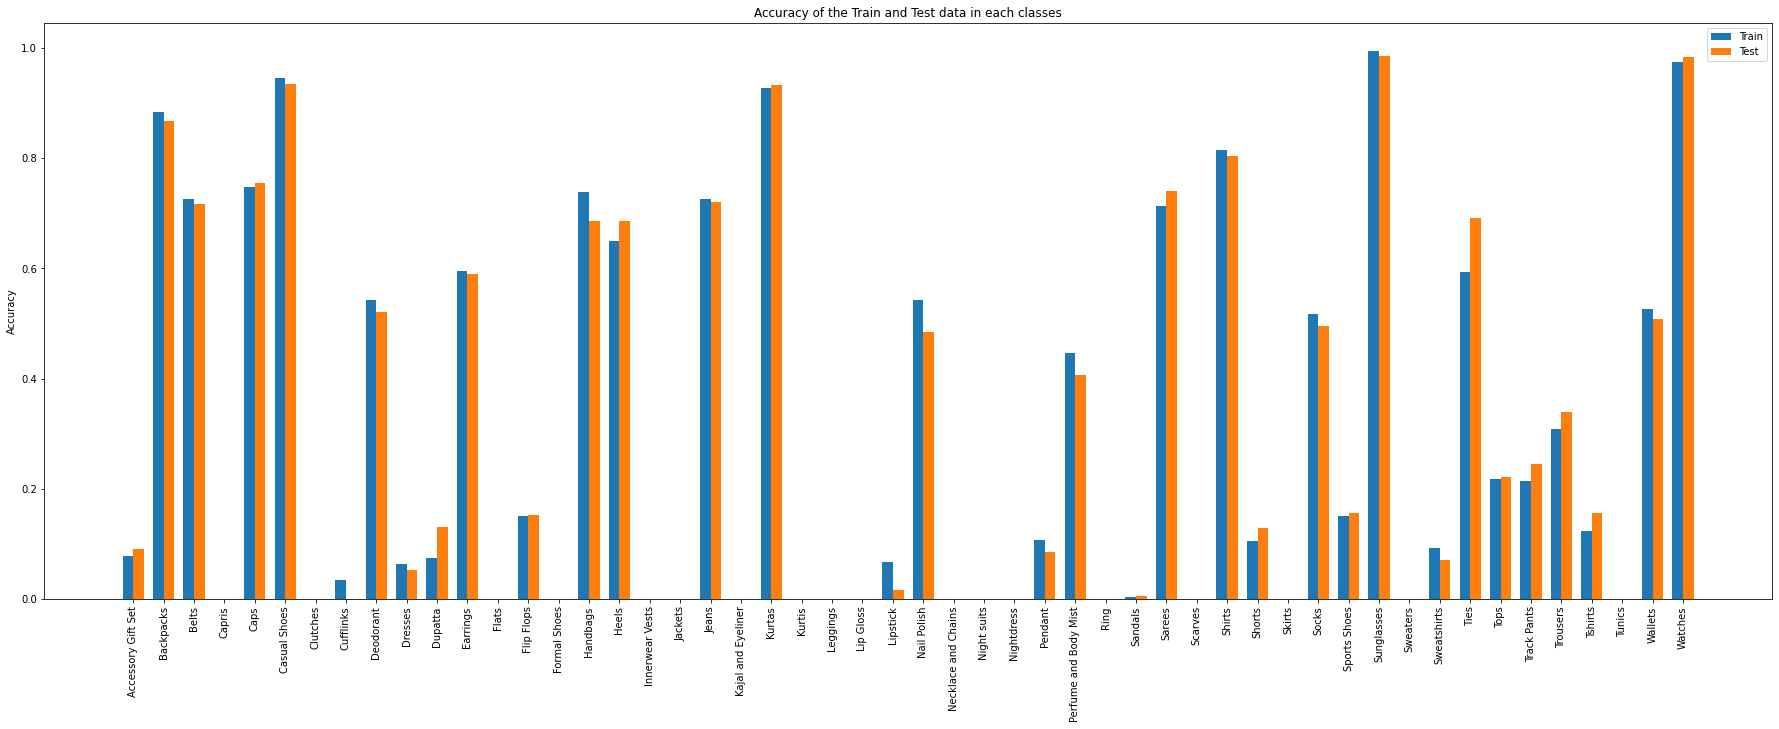

In [63]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

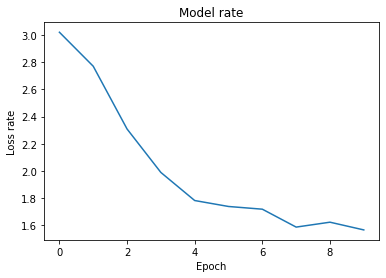

In [64]:
draw_loss_graph(loss)

In [65]:
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate, momentum = 0.98)
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: nan, time elapsed: 14.404719 seconds
epoch 2, train_loss: nan, time elapsed: 14.289706 seconds
epoch 3, train_loss: nan, time elapsed: 13.790476 seconds
epoch 4, train_loss: nan, time elapsed: 13.726902 seconds
epoch 5, train_loss: nan, time elapsed: 13.631176 seconds
epoch 6, train_loss: nan, time elapsed: 13.679094 seconds
epoch 7, train_loss: nan, time elapsed: 13.713883 seconds
epoch 8, train_loss: nan, time elapsed: 13.623779 seconds
epoch 9, train_loss: nan, time elapsed: 13.796195 seconds
epoch 10, train_loss: nan, time elapsed: 13.747983 seconds
total training time: 2.307 minutes


In [66]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 0.29866774052820566%  Test Accuracy: 0.2953020134228188%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


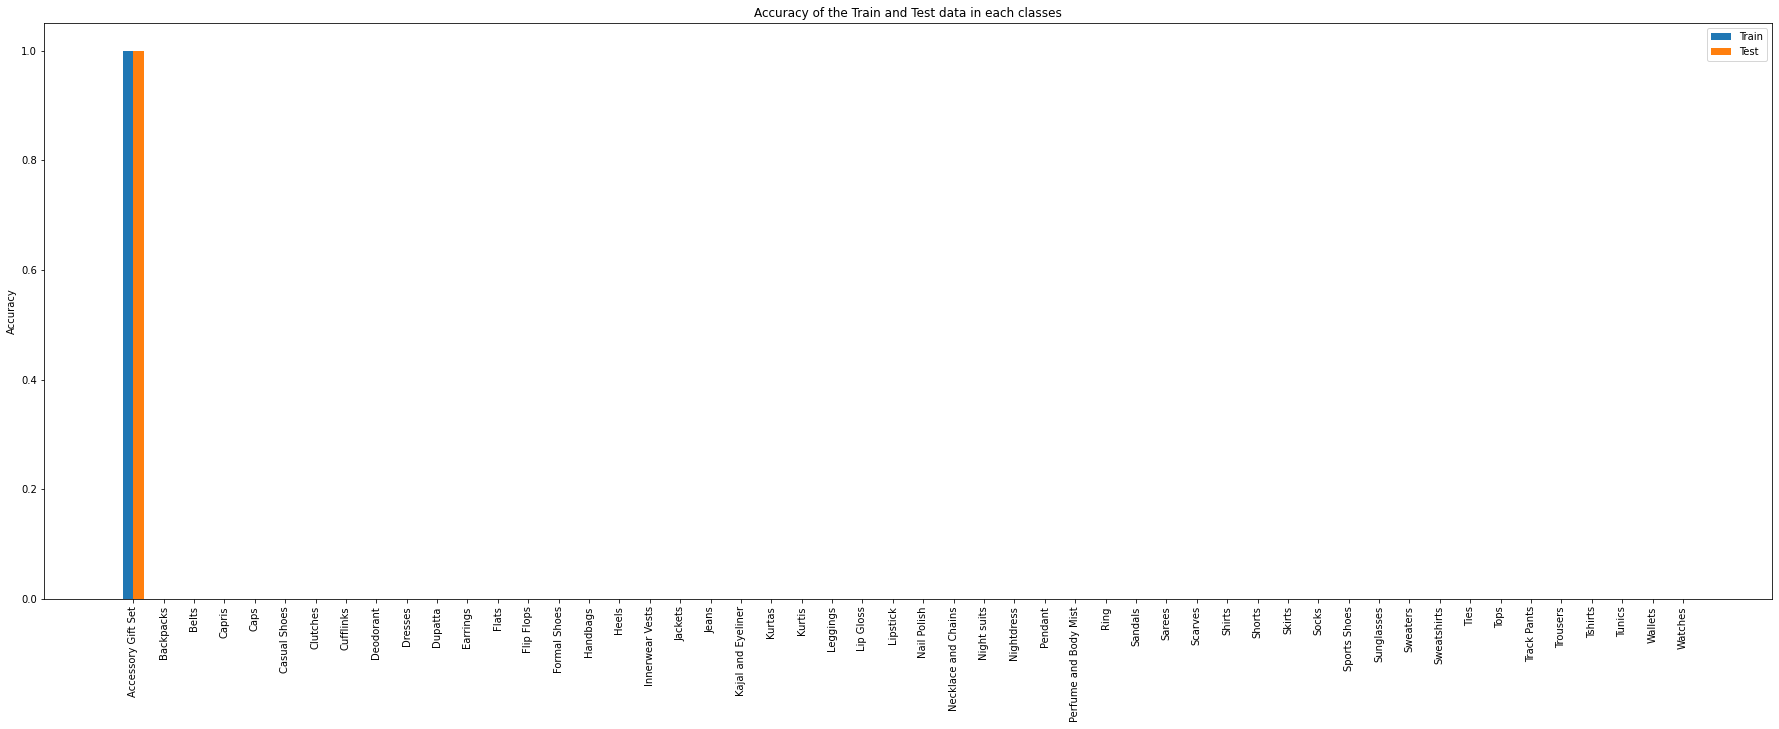

In [67]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

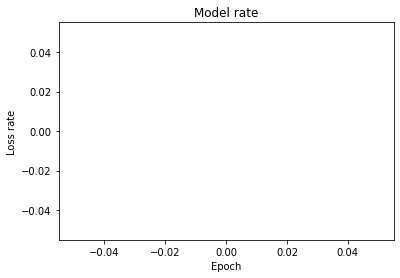

In [68]:
draw_loss_graph(loss)

In [69]:
best_momentum = 0.5

# Part 8 - c

No, as we state in the cons of the momentum, large momentum can lead to missing local optimum and hence is not good.

# Part 9 - a

In this part, we check out the effect of the number of epochs in the learning process of our model. One Epoch is when an entire dataset is passed forward and backward through the neural network only once. As we can see from the result, our model gets better accuracy as the number of epochs reaches 20. Our last best result in the accuracy metric was about `70%` but here with 20 epochs, we get about `75%`. This happens is logical because previously, we didn't receive to the optima. Just we should take care of the overfitting doesn't happen in our model which is not happening now because test and train accuracy are almost the same so we don't have overfitting here.

In [70]:
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate, momentum = best_momentum)
loss, model = fit(model, train_loader, device, criterion, optimizer, num_epochs = 20)

epoch 1, train_loss: 2.638, time elapsed: 14.120451 seconds
epoch 2, train_loss: 1.960, time elapsed: 14.057465 seconds
epoch 3, train_loss: 1.548, time elapsed: 13.823981 seconds
epoch 4, train_loss: 1.376, time elapsed: 14.430643 seconds
epoch 5, train_loss: 1.289, time elapsed: 14.677779 seconds
epoch 6, train_loss: 1.182, time elapsed: 14.487403 seconds
epoch 7, train_loss: 1.101, time elapsed: 14.445781 seconds
epoch 8, train_loss: 1.059, time elapsed: 13.538768 seconds
epoch 9, train_loss: 0.997, time elapsed: 13.906904 seconds
epoch 10, train_loss: 0.958, time elapsed: 14.437961 seconds
epoch 11, train_loss: 0.925, time elapsed: 14.020732 seconds
epoch 12, train_loss: 0.910, time elapsed: 13.914991 seconds
epoch 13, train_loss: 0.876, time elapsed: 13.817334 seconds
epoch 14, train_loss: 0.837, time elapsed: 13.81869 seconds
epoch 15, train_loss: 0.820, time elapsed: 13.82744 seconds
epoch 16, train_loss: 0.801, time elapsed: 14.17718 seconds
epoch 17, train_loss: 0.784, time el

In [71]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 75.88174099802006%  Test Accuracy: 73.32885906040268%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


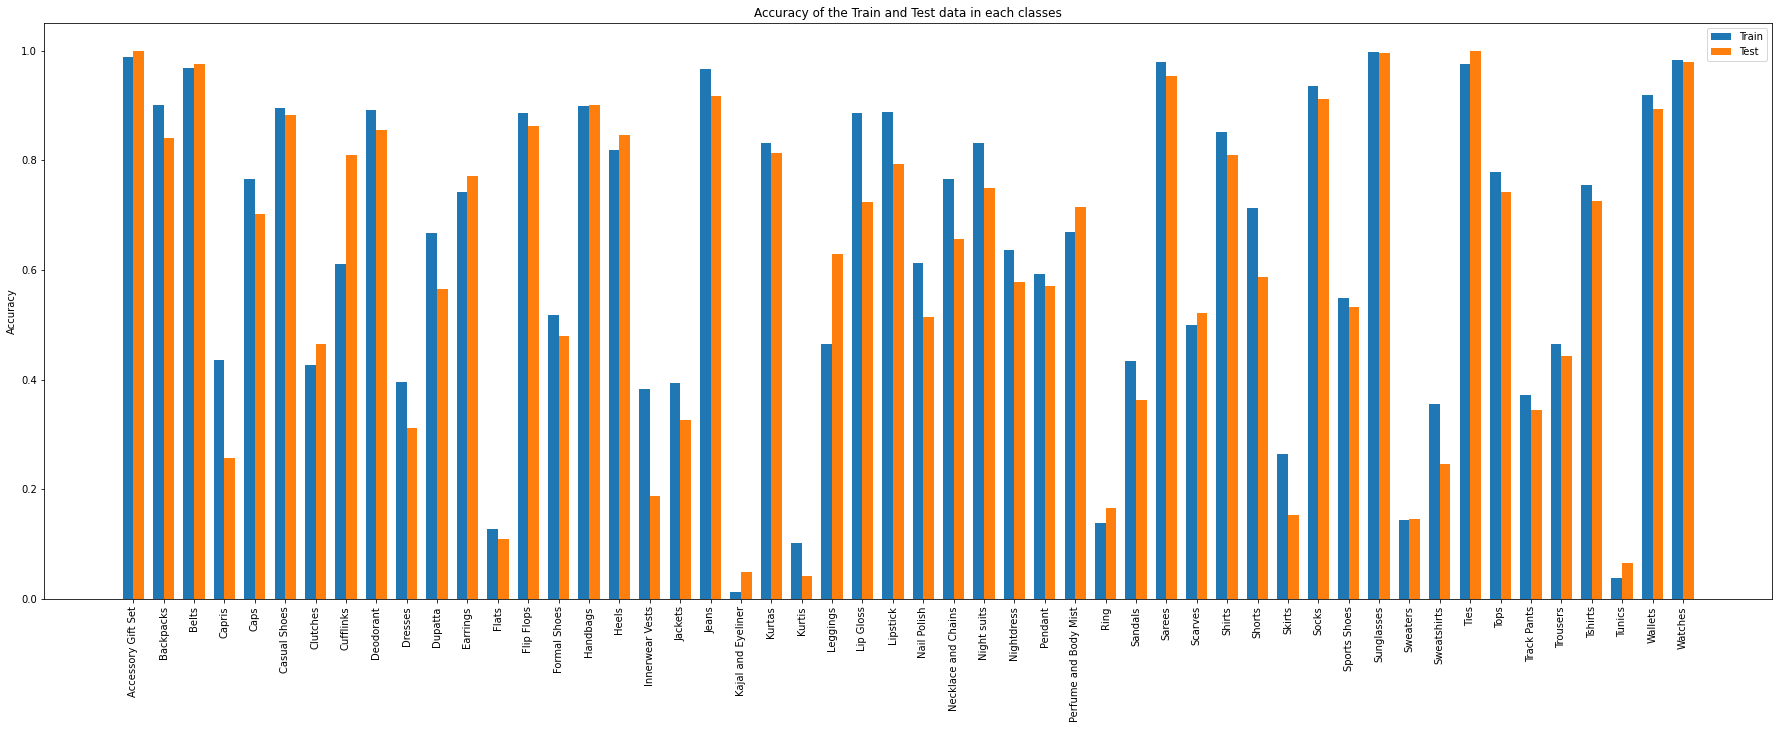

In [72]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

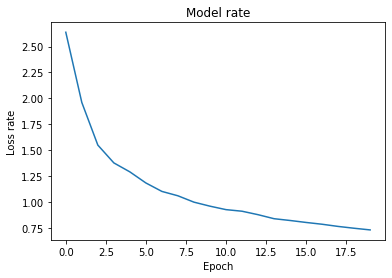

In [73]:
draw_loss_graph(loss)

# Part 9 - b

Gradient Descent is an iterative optimization algorithm used to find the best results. The algorithm is iterative means that we need to get the results multiple times to get the most optimal result. The iterative quality of the gradient descent helps a under-fitted graph to make the graph fit optimally to the data. As the number of epochs increases, more number of times the weight are changed in the neural network and the curve goes from underfitting to optimal to overfitting curve.
<img src="Images/4.png"/>

# Part 9 - c

Base on what we said in the last part, increasing the number of epochs doesn't always lead to better results and maybe we face overfitting. So we should take care of this happen.

# Part 10

Here in this section, we will compare different activation functions for finding which one will work better in our model. We will compare these functions:

<img src="Images/6.png" style="height:160px;"/>
<img src="Images/7.png" style="height:80px;"/>

As we can see from the results, we have about `70%`, `70%` and `69%` accuracy when we use `ReLu`, `tanh` and `Leaky ReLu` as activation function, respectively. So, in my model these activation functions don't have considerable differences. 

In [74]:
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate, momentum = best_momentum, activation_funtion = F.tanh)
loss, model = fit(model, train_loader, device, criterion, optimizer)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 2.292, time elapsed: 13.96543 seconds
epoch 2, train_loss: 1.579, time elapsed: 14.576416 seconds
epoch 3, train_loss: 1.372, time elapsed: 14.267303 seconds
epoch 4, train_loss: 1.230, time elapsed: 13.888168 seconds
epoch 5, train_loss: 1.142, time elapsed: 13.961562 seconds
epoch 6, train_loss: 1.094, time elapsed: 13.829291 seconds
epoch 7, train_loss: 1.030, time elapsed: 14.27459 seconds
epoch 8, train_loss: 0.984, time elapsed: 14.668184 seconds
epoch 9, train_loss: 0.954, time elapsed: 14.531151 seconds
epoch 10, train_loss: 0.898, time elapsed: 14.424322 seconds
total training time: 2.373 minutes


In [75]:
train_test_accuracy(model, train_loader, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Accuracy: 70.09966777408638%  Test Accuracy: 68.49664429530202%


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


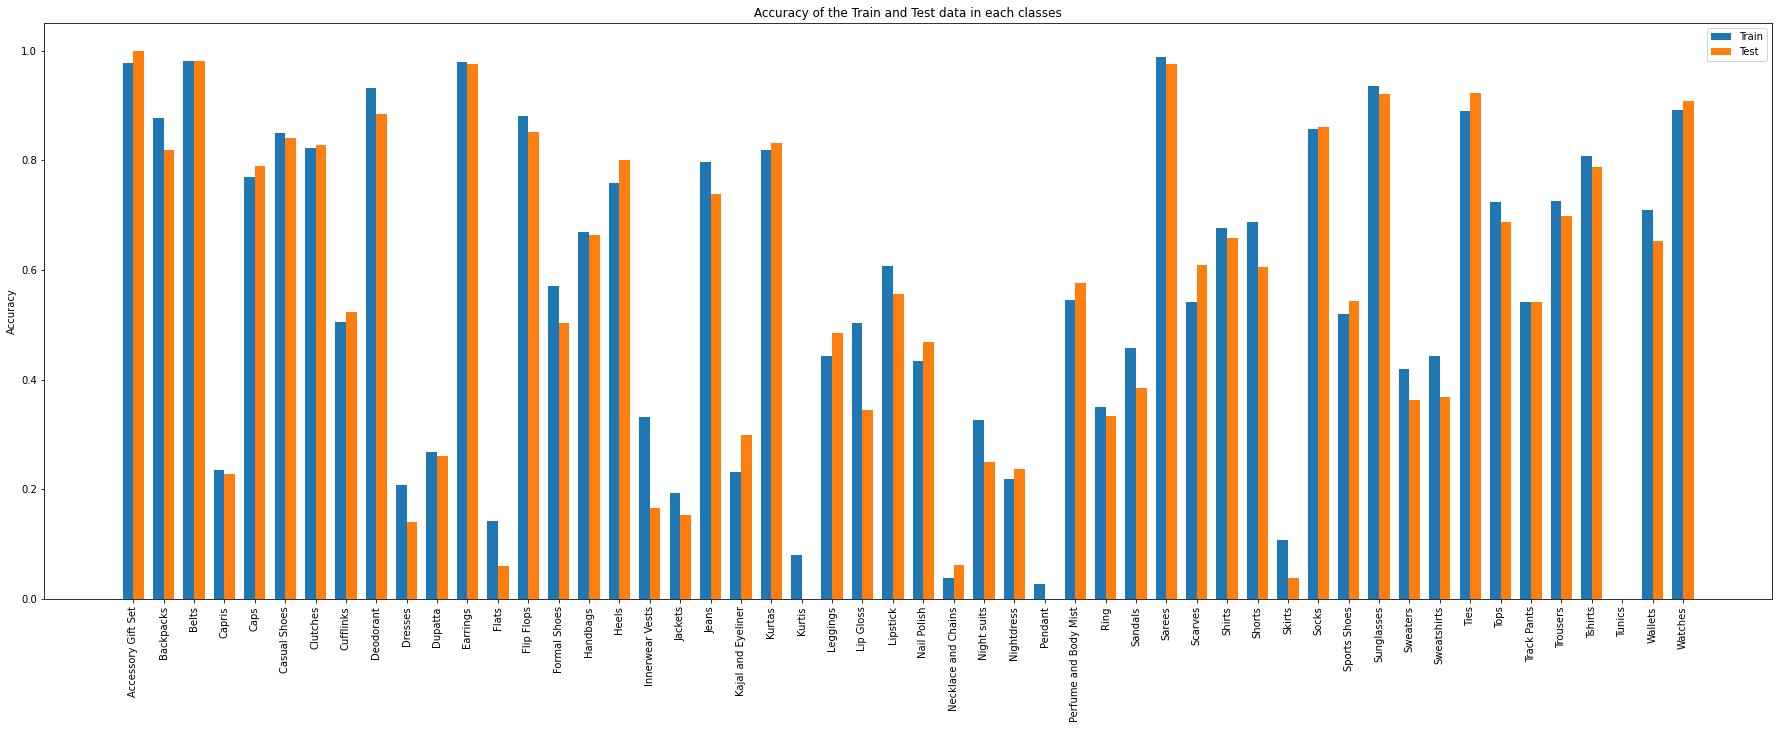

In [76]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

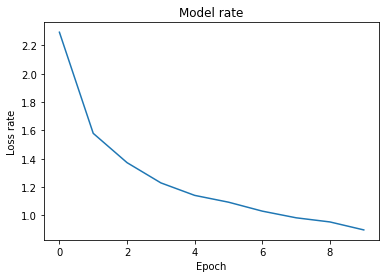

In [77]:
draw_loss_graph(loss)

In [78]:
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate, momentum = best_momentum, activation_funtion = F.leaky_relu)
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 2.614, time elapsed: 13.898881 seconds
epoch 2, train_loss: 1.959, time elapsed: 13.784532 seconds
epoch 3, train_loss: 1.539, time elapsed: 13.720623 seconds
epoch 4, train_loss: 1.376, time elapsed: 13.589324 seconds
epoch 5, train_loss: 1.261, time elapsed: 13.705625 seconds
epoch 6, train_loss: 1.160, time elapsed: 14.016964 seconds
epoch 7, train_loss: 1.101, time elapsed: 13.841315 seconds
epoch 8, train_loss: 1.052, time elapsed: 13.965251 seconds
epoch 9, train_loss: 0.995, time elapsed: 14.038314 seconds
epoch 10, train_loss: 0.956, time elapsed: 13.939486 seconds
total training time: 2.308 minutes


In [79]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 69.75066277391859%  Test Accuracy: 68.52348993288591%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


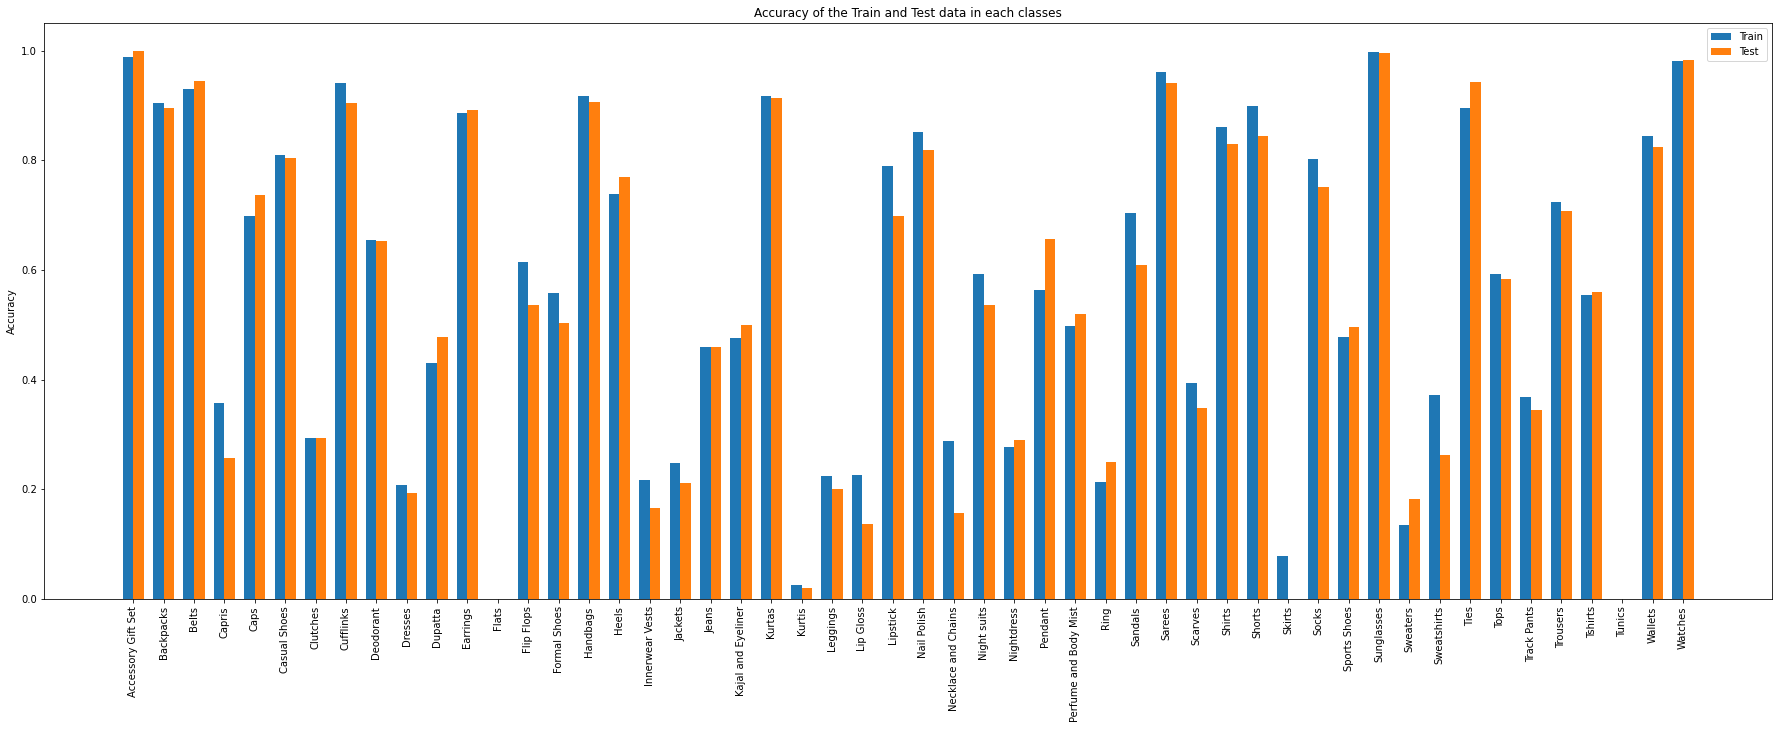

In [80]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

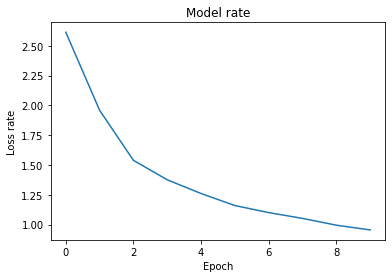

In [81]:
draw_loss_graph(loss)

# Part 11 - a

Overfitting is a phenomenon where a machine learning model models the training data too well but fails to perform well on the testing data. Performing sufficiently good on testing data is considered as a kind of ultimatum in machine learning. There are quite a number of techniques which help to prevent overfitting. Regularization is one such technique. In short, Regularization in machine learning is the process of regularizing the parameters that constrain, regularizes, or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, avoiding the risk of Overfitting. Regularization is a technique used for tuning the function by adding an additional penalty term in the error function. The additional term controls the excessively fluctuating function such that the coefficients don’t take extreme values. This technique of keeping a check or reducing the value of error coefficients are called shrinkage methods or weight decay in case of neural networks.

# Part 11 - b

Weight decay is equivalent to the `L2 Regularization` method for SGD by a reparameterization of the weight decay factor based on the learning rate. The Equation of weight decay is given below with λ being the decay factor. 
<img src="Images/8.png" style="height:50px;"/>
L2 regularization can be proved equivalent to weight decay in the case of SGD. The proove can be find in this [link](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd).

# Part 11 - c

Now we train our model with `weight_decay` parameter equal to 0.1. As we can see, the rate of decreasing the train_loss decreased significantly and the accuracy becomes `15%`. So this parameter reduces our model efficiency.

In [82]:
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate, momentum = best_momentum, weight_decay=0.1)
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 3.132, time elapsed: 14.094931 seconds
epoch 2, train_loss: 2.954, time elapsed: 13.966735 seconds
epoch 3, train_loss: 2.956, time elapsed: 14.119517 seconds
epoch 4, train_loss: 2.949, time elapsed: 14.003158 seconds
epoch 5, train_loss: 2.948, time elapsed: 14.048671 seconds
epoch 6, train_loss: 2.936, time elapsed: 14.668639 seconds
epoch 7, train_loss: 2.922, time elapsed: 14.881402 seconds
epoch 8, train_loss: 2.942, time elapsed: 14.663216 seconds
epoch 9, train_loss: 2.943, time elapsed: 14.653371 seconds
epoch 10, train_loss: 2.939, time elapsed: 14.496646 seconds
total training time: 2.393 minutes


In [83]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 15.027349911070841%  Test Accuracy: 15.355704697986576%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


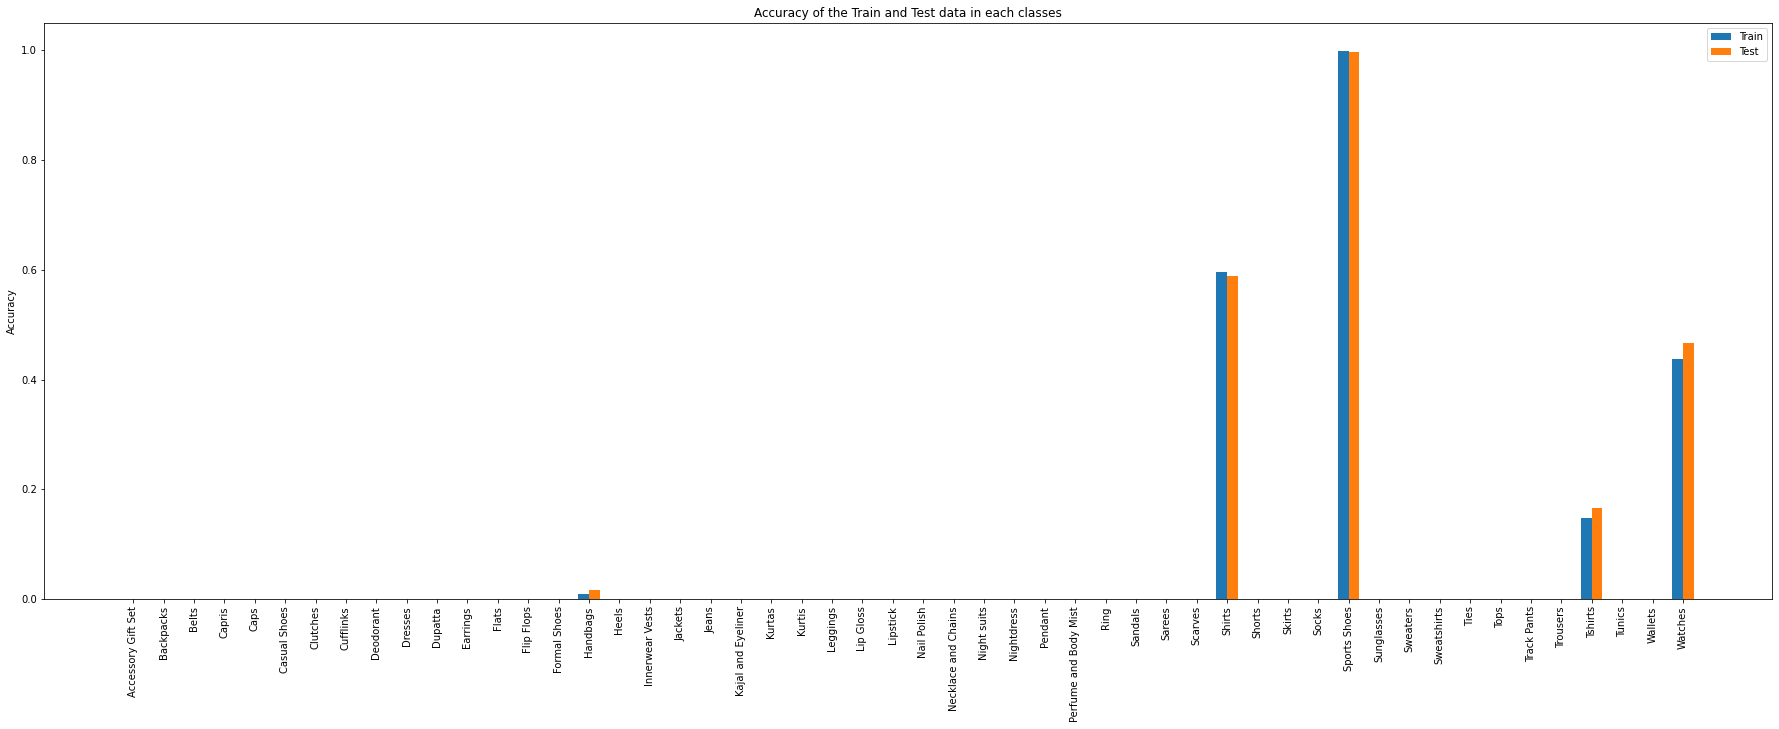

In [84]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

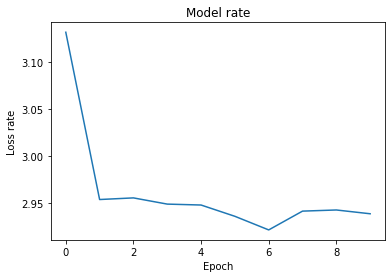

In [85]:
draw_loss_graph(loss)

# Part 11 - d

As we can see from the result of this section and the part 8, we can conclude that `weight_decay` of zero works best for our model because the accuaracy of that model is better than the other one. This result is maybe because of this fact that our model didn't face overfitting that regularization can help it or maybe we need to set smaller `weight_decay` parameter.

In [86]:
model, device, criterion, optimizer = configuration(learning_rate = best_learning_rate, momentum = best_momentum, weight_decay=0.01)
loss, model = fit(model, train_loader, device, criterion, optimizer)

epoch 1, train_loss: 2.733, time elapsed: 13.955259 seconds
epoch 2, train_loss: 2.188, time elapsed: 14.052387 seconds
epoch 3, train_loss: 1.938, time elapsed: 14.217575 seconds
epoch 4, train_loss: 1.760, time elapsed: 14.0953 seconds
epoch 5, train_loss: 1.650, time elapsed: 14.177152 seconds
epoch 6, train_loss: 1.616, time elapsed: 14.956173 seconds
epoch 7, train_loss: 1.568, time elapsed: 14.042779 seconds
epoch 8, train_loss: 1.641, time elapsed: 14.084482 seconds
epoch 9, train_loss: 1.551, time elapsed: 14.073055 seconds
epoch 10, train_loss: 1.600, time elapsed: 14.630612 seconds
total training time: 2.371 minutes


In [87]:
train_test_accuracy(model, train_loader, test_loader)

Train Accuracy: 46.96801906104232%  Test Accuracy: 47.355704697986575%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


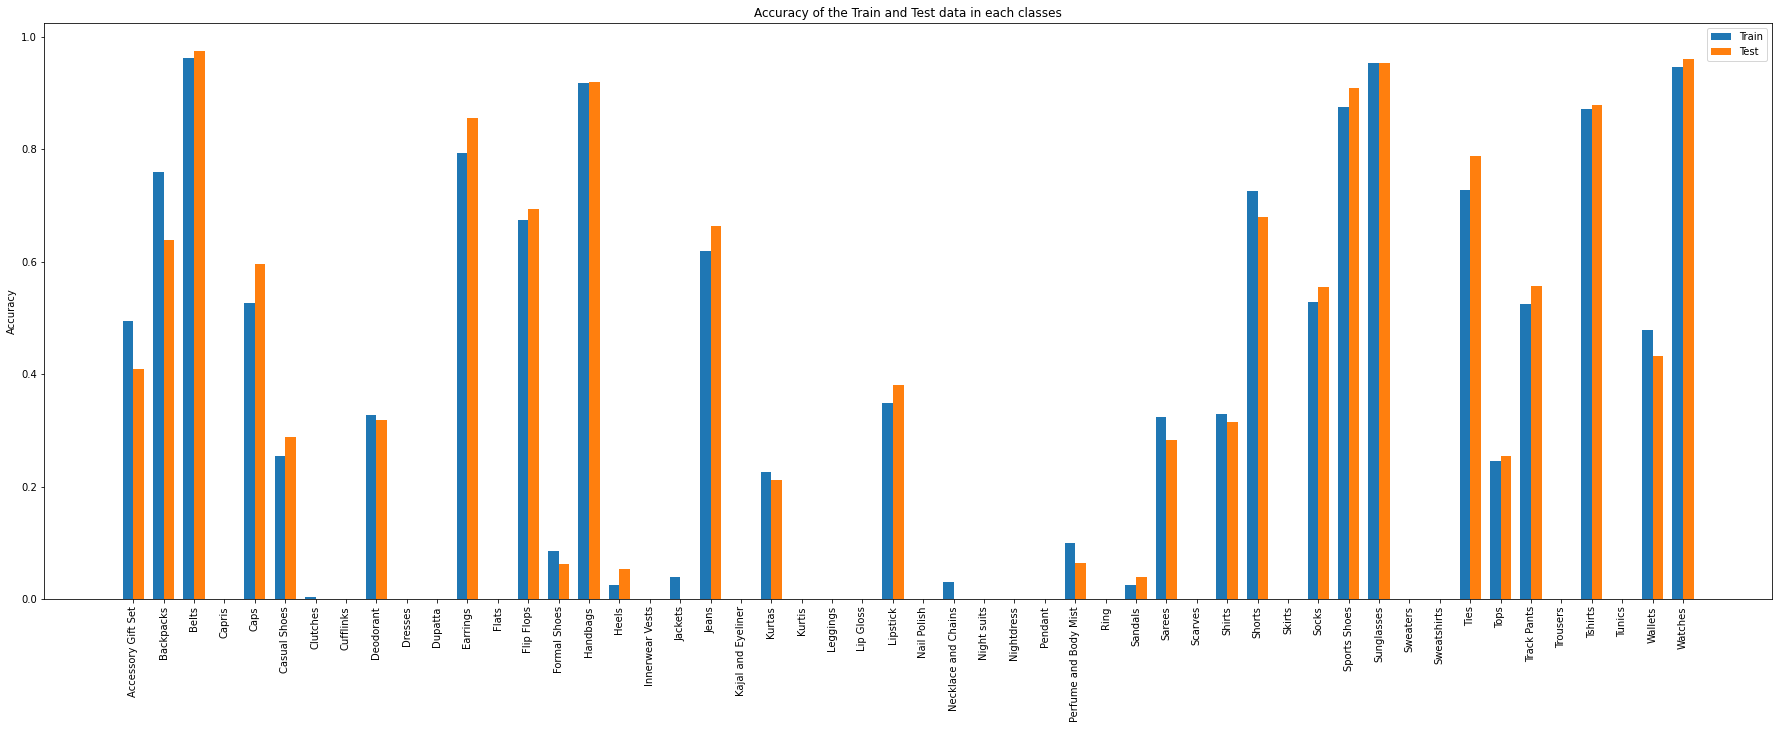

In [88]:
train_accuracy, test_accuracy = classes_accuracy(model, train_loader, test_loader, classes)
draw_classes_accuracy_graph(train_accuracy, test_accuracy)

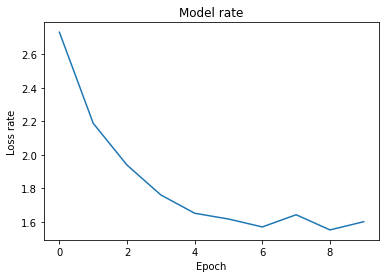

In [89]:
draw_loss_graph(loss)